## Exploration Plots Macys _ Repurchase

In this note book we have

1.frequency plots.

2.Stacked plots (by taking two categorical variables)

3.Stacked plots(hist plots) (Continuous vs Categorical variable)

4.combined frequency and stacked plots.

5.age distribution plot.

#### Plots for PPT - return status 

In [1]:
#### Libraries

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
font = {'family': 'serif','color':  'darkred','weight': 'normal','size': 14,}

from scipy.stats import mode
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import os
os.chdir("C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Ashwini\\lavanya_code_exe")

In [3]:
#### Sales data with Product Details Attached 
    #Find the Source SQL from Vaibhav and collate

main_data = pd.read_csv("Macys_Repurchase_Product.csv",encoding='latin-1')
# main_data.head(5)
    
#### Customer Data 

cust_data = pd.read_csv("Customer_data.csv",encoding='latin-1')
# cust_data.head(5)

#### RFM Score Data

RFM_data = pd.read_csv("RFM_score_data.csv")
# RFM_data.head(5)

#### Customer History of returns

cust_ret_data = pd.read_csv("customer_history_returns.csv")

In [4]:
count_data = main_data.groupby(['cid','upc']).size().reset_index(None)
count_data.columns = ['cid','upc','count']

In [5]:
def data_arrange(temp_data):
    temp_data['r_dt'] = pd.to_datetime(temp_data['r_dt'])
    temp_data['dt'] = pd.to_datetime(temp_data['dt'])
    temp_data = temp_data.sort_values(by="dt").reset_index(None)
    x = pd.DataFrame(temp_data.iloc[0]).T
    y = pd.DataFrame(temp_data.iloc[1]).T

    z = x.merge(y,on=['cid','upc'])
    z.drop(['index_x','index_y',u'web_prod_id_x', u'PROD_DESC_x',u'PROD_TYP_DESC_x', u'BRND_NM_x', u'VND_NM_x', u'GMM_DESC_x',u'PARENT_MDSE_DIVN_DESC_x', u'BUYER_DESC_x', u'MDSE_DEPT_DESC_x',u'LBL_NM_x'],1,inplace=True)
    z.columns = ['cid','upc','oid_old','buy_dt_old','r_dt_old','prc_old','qty_old','amt_old','r_qty_old', 'r_amt_old',
            'oid_new','buy_dt_new','r_dt_new','prc_new','qty_new','amt_new','r_qty_new', u'r_amt_new','web_prod_id', 
             u'PROD_DESC', u'PROD_TYP_DESC',u'BRND_NM', u'VND_NM', u'GMM_DESC', u'PARENT_MDSE_DIVN_DESC',
            u'BUYER_DESC', u'MDSE_DEPT_DESC', u'LBL_NM']
    
    z['prc_chg_dollar'] = z['prc_new'] - z['prc_old']
    z['prc_chg_pct'] = z['prc_chg_dollar']/z['prc_new']
    
    z['time_to_new_purchase'] = (z['buy_dt_new'] - z['buy_dt_old']).dt.days 
    z['prc_chg_per_day'] = z['prc_chg_dollar']/(z['time_to_new_purchase']+1)
    
    z['return_duration_from_recent_buy'] = np.nan
    
    z['return_status'] = "N"
    z['returned_old_flag'] = "N"
    z['return_status_repurchase'] = 0
    
    if np.isnan(z.r_qty_new.values[0]) & np.isnan(z.r_qty_old.values[0]):
        z['return_status'] = "Both Kept"
        z['return_status_repurchase'] = 0
    elif ((not np.isnan(z.r_qty_new.values[0])) & (not np.isnan(z.r_qty_old.values[0]))):
        z['return_status'] = "Both Returned"
        z['return_status_repurchase'] = 1
    elif ((np.isnan(z.r_qty_new.values[0])) & (not np.isnan(z.r_qty_old.values[0]))):
        z['return_status'] = "Returned Old"
        if (z.r_dt_old.values[0] != "") & (z.buy_dt_new.values[0] > z.r_dt_old.values[0]):
            z['return_duration_from_recent_buy'] = (z['r_dt_old'] - z['buy_dt_new']).dt.days
            z['returned_old_flag'] = "Y"
            z['return_status_repurchase'] = 0
            
        else:
            z['return_status_repurchase'] = 1
            z['returned_old_flag'] = "N"
    elif ((not np.isnan(z.r_qty_new.values[0])) & (np.isnan(z.r_qty_old.values[0]))):
        z['return_status'] = "Returned New"
        z['return_status_repurchase'] = 1
        
    (z.return_status=="Returned Old")&(z.returned_old_flag=="") 
    
    return z



count_2 = count_data[count_data['count']==2]
new_data = pd.DataFrame()
for ix in range(len(count_2)):
    temp_cid = count_2.iloc[ix].cid
    temp_upc = count_2.iloc[ix].upc
    temp_data = main_data[(main_data.cid == temp_cid) & (main_data.upc == temp_upc) ]
    temp_data = data_arrange(temp_data)
    
    new_data = new_data.append(temp_data)

    
#### Print a sample of processed sales_prod data
print("Example of data after all processing is done on sales data\n")
new_data.head(5)

Example of data after all processing is done on sales data



,cid,upc,oid_old,buy_dt_old,r_dt_old,prc_old,qty_old,amt_old,r_qty_old,r_amt_old,...,MDSE_DEPT_DESC,LBL_NM,prc_chg_dollar,prc_chg_pct,time_to_new_purchase,prc_chg_per_day,return_duration_from_recent_buy,return_status,returned_old_flag,return_status_repurchase
0,"10,000,242","706,255,805,079",1289184165,2016-11-08 00:00:00,2016-12-01 00:00:00,11.99,1,11.99,1,11.99,...,CHARTER CLUB PLUS,CHARTER CLUB,-4.25,-0.549096,8,-0.472222,NaN,Returned Old,N,1
0,"10,000,242","785,498,037,447",1264484832,2016-10-19 00:00:00,2016-12-01 00:00:00,45,1,45,1,45,...,GIRLS 3-24 MONTHS,BONNIE JEAN,-21.01,-0.875782,31,-0.656563,NaN,Returned Old,N,1
0,"10,000,242","888,982,520,798",1298459769,2016-11-16 00:00:00,2016-12-01 00:00:00,15.99,1,15.99,1,15.99,...,KAREN SCOTT PLUS,KAREN SCOTT,-3,-0.230947,1,-1.5,NaN,Returned Old,N,1
0,"10,001,026","829,092,279,268",1298532543,2016-11-18 00:00:00,NaT,29.99,1,29.99,NaN,NaN,...,XOXO,XOXO,-6.52,-0.277801,1,-3.26,NaN,Returned New,N,1
0,"10,002,227","888,572,943,099",1202126220,2016-05-14 00:00:00,2016-06-16 00:00:00,35.99,1,35.99,1,35.99,...,LAUREN PLUS,LAUREN,-18,-1.00056,28,-0.62069,NaN,Returned Old,N,1


#### Dropping all columns where it has all missing values only 


In [8]:
### changing the dataset name to avoid confusion
main_data = new_data
#### Dropping all columns where it has all missing values only ! 
main_data = main_data.dropna(axis=1, how='all')
cust_data = cust_data.dropna(axis=1, how='all')
RFM_data = RFM_data.dropna(axis=1, how='all')

In [13]:
main_data.describe()

,time_to_new_purchase,return_duration_from_recent_buy,return_status_repurchase
count,8923.000000,433.000000,8923.000000
mean,40.005828,-38.399538,0.472375
std,63.643566,55.666248,0.499264
min,0.000000,-313.000000,0.000000
25%,3.000000,-47.000000,0.000000
50%,11.000000,-18.000000,0.000000
75%,45.000000,-5.000000,1.000000
max,356.000000,-1.000000,1.000000


In [14]:
def quality_report(df):
    """
        Purpose : to create a report of column wise missing value and unique value counts and datatypes 
        Input : Dataframe
        Output : Dataframe with columns names, 
        types, no of observations, no of missing rows, No of unique values,
        % of data avaliable , % of data missing and 
        'Average','SD','MIN','25%','50%','75%','MAX'
        Usage : quality_report(df)

    """
    quality_df = pd.DataFrame()
    quality_df['Col_Name']=df.columns.sort_values()
    sorted_cols = df.columns.sort_values()
    quality_df['Col_Type'] = df[sorted_cols].dtypes.values
    quality_df['No_Of_Observations']=df[sorted_cols].apply(lambda x:len(x)).values
    quality_df['No_Of_Missing_Rows'] = df[sorted_cols].apply(lambda x:np.sum(pd.isnull(x))).values
    quality_df['No_Of_Uniques'] = df[sorted_cols].apply(lambda x:len(x.unique())).values
    quality_df['Data_Avaliable'] = quality_df['No_Of_Observations']-quality_df['No_Of_Missing_Rows']
    quality_df['AvailablePercentage']=np.round(quality_df['Data_Avaliable']/quality_df['No_Of_Observations'],2)
    quality_df['Miss_Pct']=np.round(1-quality_df['AvailablePercentage'],2)
    summary = df.describe().T.reset_index()
    summary.columns=['Col_Name','count','Average','SD','MIN','25%','50%','75%','MAX']
    summary.drop(['count'],axis=1,inplace=True)
    quality_df=pd.merge(quality_df,summary,left_on='Col_Name',right_on='Col_Name',how='outer')
    #quality_df.apply(lambda x:fillna(0, inplace=True))
    quality_df = quality_df.fillna(0)
    return quality_df




def quality_report_User_Edit(df):
    
    """
        Purpose : to create a report of column wise missing value and unique value counts and datatypes 
        Input : Dataframe
        Output : Dataframe with columns names, 
        types, no of observations, no of missing rows, No of unique values,
        % of data avaliable , % of data missing and 
        'Average','SD','MIN','25%','50%','75%','MAX'
        Usage : quality_report(df)

    """
    quality_df = pd.DataFrame()
    quality_df['Col_Name']=df.columns.sort_values()
    sorted_cols = df.columns.sort_values()
    quality_df['Col_Type'] = df[sorted_cols].dtypes.values
    quality_df['No_Of_Observations']=df[sorted_cols].apply(lambda x:len(x)).values
    quality_df['No_Of_Missing_Rows'] = df[sorted_cols].apply(lambda x:np.sum(pd.isnull(x))).values
    quality_df['No_Of_Uniques'] = df[sorted_cols].apply(lambda x:len(x.unique())).values
    quality_df['AvailablePercentage']=np.round(quality_df['Data_Avaliable']/quality_df['No_Of_Observations'],2)
    quality_df = quality_df.fillna(0)
    quality_df['Col_Type_Def'] = ""
    quality_df['Col_Keep'] = ""
    quality_df['Impute_method'] = ""
    quality_df['Levels_to_Keep'] = ""
    return quality_df

In [15]:
######### ---------------- Select only specific columns ----------- ############# 

def colums_to_select(main_data,filePath):
    """
    Purpose : Takes in a dataset and a CSV where column to select are defined and 
    selects only those columns.
    Inputs: Dataframe , File name with path in python format if file is not in CWD. 
    Outputs: Input DataFrame with desired columns selected
    Usage : type_conversion(df,"path\\filename.csv")
    
    """
    quality_report = pd.read_csv(filePath)
    select_vars = quality_report.loc[quality_report.Col_Keep =='Y','Col_Name']
    main_data = main_data[select_vars]
    
    return(main_data)


def type_conversion(main_data,filePath):
   
    """
    Purpose : Takes in a dataset and a CSV where column types are defined and 
    converts each column in the dataset to the format specified in the CSV
    **working**: shoul Not  contains missing values in float or int type columns.
    Inputs: Dataframe to convert , File name with path in python format if file is not in CWD. 
    Outputs: Input DataFrame with desired datatype conversions
    Usage : type_conversion(df,"path\\filename.csv")
    
    """
    quality_report = pd.read_csv(filePath)
    quality_report=quality_report.loc[quality_report.Col_Keep =='Y',]
#     print(quality_report.shape)
    int_vars = quality_report.loc[quality_report.Col_Type_Def=='int64','Col_Name']
    float_vars = quality_report.loc[quality_report.Col_Type_Def=='float64','Col_Name']
    obj_vars = quality_report.loc[quality_report.Col_Type_Def=='object','Col_Name']
    
    for cols in int_vars:
        main_data[cols]=main_data[cols].astype('int64')
    for cols in float_vars:
        main_data[cols]=main_data[cols].astype('float64')
    for cols in obj_vars:
        main_data[cols]=main_data[cols].astype('object')
    return(main_data)


In [16]:
main_data.describe()

,time_to_new_purchase,return_duration_from_recent_buy,return_status_repurchase
count,8923.000000,433.000000,8923.000000
mean,40.005828,-38.399538,0.472375
std,63.643566,55.666248,0.499264
min,0.000000,-313.000000,0.000000
25%,3.000000,-47.000000,0.000000
50%,11.000000,-18.000000,0.000000
75%,45.000000,-5.000000,1.000000
max,356.000000,-1.000000,1.000000


#### Distribution Plots from Sales data

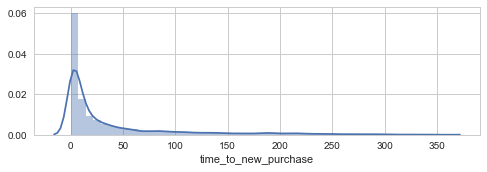

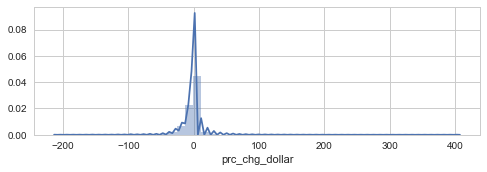

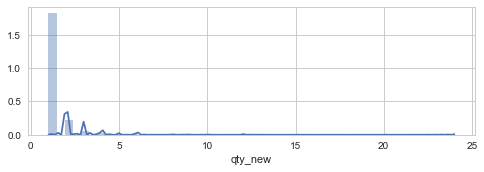

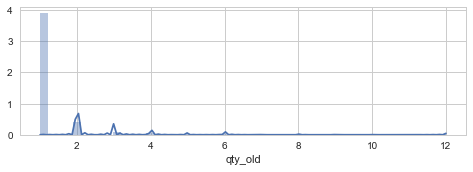

In [18]:
for col in ['time_to_new_purchase','prc_chg_dollar','qty_new','qty_old']:
    #print(data_pc[col])
    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot2grid((3,1), (0,0))
    g=sns.distplot(new_data[col])
   

#### return_status vs return_status_repurchase :


In [24]:
def bivar_plot1(data,attribute,fig_widht=12,fig_height=6,width=0.3,Stacked=True,legend=True):
    fig, axs = plt.subplots(1,2,figsize=(fig_widht,fig_height),squeeze=0)
    sorted_names = data[attribute].value_counts().index
    temp_df = pd.crosstab(data[attribute],data.return_status_repurchase,normalize='index')
    temp_df.reset_index(inplace=True)
    temp_df.columns = ['Levels','return_no','return_yes']
    temp_df2 = pd.DataFrame(sorted_names)
    temp_df2.columns = ['Levels']
    df_Final = pd.merge(temp_df2,temp_df,left_on='Levels',right_on='Levels')
    df_Final.plot(kind='bar',stacked=Stacked,legend=0,color=['#FF6D31','#29A2C6'],ax=axs[0,0],width=width)
    axs[0,0].set_xticklabels(df_Final.Levels, rotation='90',size=13)
    axs[0,0].set_title(attribute+ ' vs Target',size=16,fontweight='bold')
    if(legend==True):
        axs[0,0].legend(bbox_to_anchor=(1.1, 1.05),loc='right')
   
   ##-----------------plot for to notic count of each level in categorical attribute-------##
   
    data[attribute].value_counts().plot(kind='bar',ax=axs[0][1],width=width,color='#6bb69c')
    plt.title('Frequency of Categories',size=16,fontname="Arial",fontweight="bold")
    plt.setp(axs[0, 1].get_xticklabels(),rotation='90',size=13)
#     axs[0,1].set_xlabel(attribute,size=15,fontname="Calibri")
    axs[0,1].set_ylabel('Frequency',size=15,fontname="Calibri")
    #if(legend==True):
        #axs[0,1].legend(bbox_to_anchor=(1.1, 1.05),loc='right')
    plt.tight_layout()

in returned_old , 20% of data is comming uder return_no category,because here we put the flag as NO, (means when the customer returned the old product before he purchasing new product & he not returned the new product)


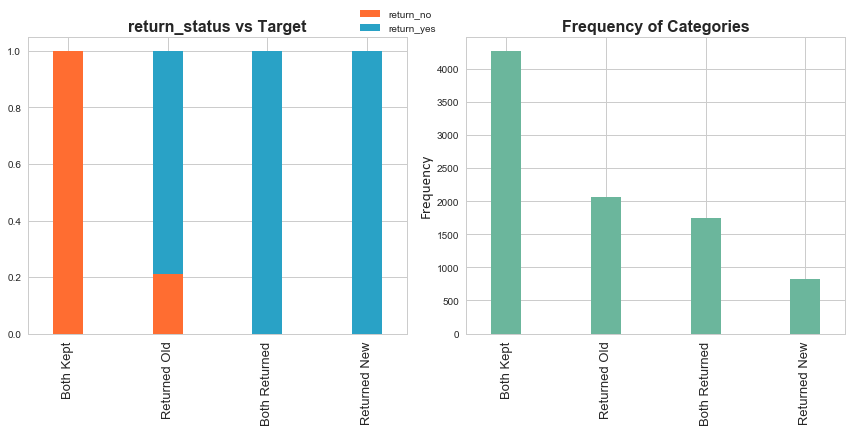

In [25]:
bivar_plot1(main_data,'return_status')
print("in returned_old , 20% of data is comming uder return_no category,because here we put the flag as NO, (means when the customer returned the old product before he purchasing new product & he not returned the new product)")

#### Frequency plot of Target Variable

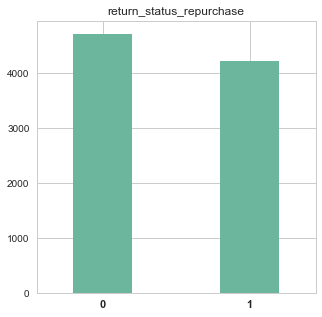

In [26]:
plt.figure(figsize=(5,5))
ax=main_data.return_status_repurchase.value_counts().plot(kind='bar',width=0.4,color=['#6bb69c'],title='return_status_repurchase')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=5,size=11,rotation=0,fontweight="bold")
plt.ticklabel_format()
#plt.savefig("f.png")


In [27]:
#### selecting specific columns 
filepath1 = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\main_Data_Dict.csv"
main_data = colums_to_select(main_data,filepath1)


main_data= main_data.reset_index()
main_data = main_data.drop(['index'],axis=1)
main_data.index


############# Some float values are missing############ 

### Dropping rows:72

indexes = list(main_data.loc[(main_data.amt_new==0)|(main_data.amt_old==0)|(main_data.prc_new==0)|(main_data.prc_old==0),].index)
main_data = main_data.drop(main_data.index[[indexes]])
#main_data.shape
main_data.apply(lambda x: sum(pd.isnull(x)))

GMM_DESC                    138
PARENT_MDSE_DIVN_DESC       138
amt_new                       0
amt_old                       0
prc_chg_dollar                0
prc_chg_pct                   0
prc_chg_per_day               0
prc_new                       0
prc_old                       0
qty_new                       0
qty_old                       0
return_status_repurchase      0
returned_old_flag             0
time_to_new_purchase          0
dtype: int64

In [28]:
main_data = type_conversion(main_data,filepath1)
main_data.return_status_repurchase.value_counts()## 52% observations has RETURNED_YES and 48% has RETURNED_NO

0    4657
1    4194
Name: return_status_repurchase, dtype: int64

### Data Distribution of final Predictors:


In [32]:
new_data['cid'] = new_data['cid'].apply(lambda x: int(x.replace(',', '')))
cust_ret_data2 = pd.merge(new_data, cust_ret_data,left_on='cid', right_on='INDIV_ID', how='left')
cust_ret_data3 = cust_ret_data2[['TOT_BUY_QTY','TOT_BUY_AMT','TOT_RET_COUNT','TOT_RET_QTY','TOT_RET_AMT','return_status','return_status_repurchase']].dropna()


In some cases TOT_BUY_QTY < TOT_RET_QTY
TOT_BUY_AMT is highly correlated with TOT_RET_AMT similarly QTY also
There are some outliers in TOT_BUY_AMT & TOT_BUY_QTY & TOT_RET_AMT & TOT_RET_QTY


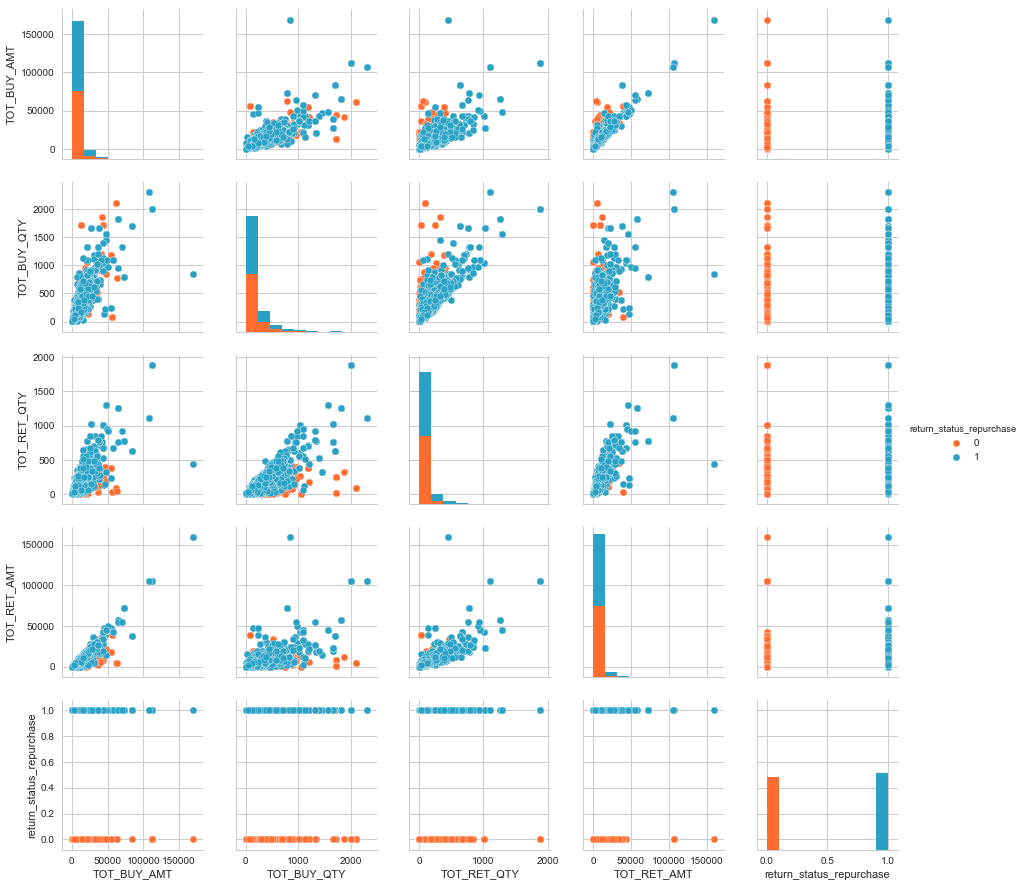

In [34]:
plt.figure(figsize=(20,10))
sns.pairplot(cust_ret_data3[['TOT_BUY_AMT','TOT_BUY_QTY','TOT_RET_QTY','TOT_RET_AMT','return_status_repurchase']],hue = 'return_status_repurchase',palette=['#FF6D31','#29A2C6'])
print("In some cases TOT_BUY_QTY < TOT_RET_QTY")
print("TOT_BUY_AMT is highly correlated with TOT_RET_AMT similarly QTY also")
print("There are some outliers in TOT_BUY_AMT & TOT_BUY_QTY & TOT_RET_AMT & TOT_RET_QTY")

#### Merge all Data Sets ###

In [35]:
filepath_cust = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\cust_Data_Dict.csv"
filepath_RFM = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\RFM_Data_Dict.csv"
filepath_main = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\main2_Data_Dict.csv"

new_data = colums_to_select(new_data,filepath_main)
cust_data = colums_to_select(cust_data,filepath_cust)
RFM_data = colums_to_select(RFM_data,filepath_RFM)

## Added 
RFM_data.loc[RFM_data.EXT_ONLN_FRST_PURCH_DT=="0001-01-01", 'EXT_ONLN_FRST_PURCH_DT'] = "01-01-01"
RFM_data.loc[RFM_data.FRST_PURCH_DT=="1-01-01", 'FRST_PURCH_DT'] = "01-01-01"
RFM_data.loc[RFM_data.FRST_PURCH_DT=="0001-01-01", 'FRST_PURCH_DT'] = "01-01-01"
RFM_data.loc[RFM_data.EXT_ONLN_FRST_PURCH_DT=="1-01-01", 'EXT_ONLN_FRST_PURCH_DT'] = "01-01-01"

dates_consider=['ONLN_FRST_PURCH_DT','ONLN_LST_PURCH_DT','STR_FRST_PURCH_DT','STR_LST_PURCH_DT','LST_PURCH_DT','FRST_PURCH_DT']
for col in dates_consider:
    RFM_data[col]=pd.to_datetime(RFM_data[col])


#### Observations

In [36]:
print("How ONLN_FRST_PURCH_DT > ONLN_LST_PURCH_DT ? ")
print("How FRST_PURCH_DT > LST_PURCH_DT ?")
print("In some cases amt_new == 0")
print("HOW TOT_BUY_QTY < TOT_RET_QTY")
print("RFM_SEG_IND is having 0.0- level, we are removed those levels,we have 3-instances like that")

How ONLN_FRST_PURCH_DT > ONLN_LST_PURCH_DT ? 
How FRST_PURCH_DT > LST_PURCH_DT ?
In some cases amt_new == 0
HOW TOT_BUY_QTY < TOT_RET_QTY
RFM_SEG_IND is having 0.0- level, we are removed those levels,we have 3-instances like that


In [37]:
print(RFM_data.loc[RFM_data.ONLN_FRST_PURCH_DT > RFM_data.ONLN_LST_PURCH_DT,['ONLN_FRST_PURCH_DT','ONLN_LST_PURCH_DT']].head(2))
print("\n\n"+'  No of instances',RFM_data.loc[RFM_data.ONLN_FRST_PURCH_DT > RFM_data.ONLN_LST_PURCH_DT,['ONLN_FRST_PURCH_DT','ONLN_LST_PURCH_DT']].shape)
print("-------------------------------")
print("\n\n")
print( RFM_data.loc[RFM_data.FRST_PURCH_DT > RFM_data.LST_PURCH_DT,['FRST_PURCH_DT','LST_PURCH_DT']].head(2))
print("\n\n"+'  No of instances', RFM_data.loc[RFM_data.FRST_PURCH_DT > RFM_data.LST_PURCH_DT,['FRST_PURCH_DT','LST_PURCH_DT']].shape)
print("-------------------------------")
print("\n\n")
print(cust_ret_data.loc[cust_ret_data.TOT_BUY_AMT < cust_ret_data.TOT_RET_AMT,['TOT_BUY_AMT','TOT_RET_AMT']].head(2))
print("\n\n"+'  No of instances', cust_ret_data.loc[cust_ret_data.TOT_BUY_AMT < cust_ret_data.TOT_RET_AMT,['TOT_BUY_AMT','TOT_RET_AMT']].shape)
print("-------------------------------")
print("\n\n")
print(cust_ret_data.loc[cust_ret_data.TOT_BUY_QTY < cust_ret_data.TOT_RET_QTY,['TOT_BUY_QTY','TOT_RET_QTY']].head(2))
print("\n\n"+'No of instances',cust_ret_data.loc[cust_ret_data.TOT_BUY_QTY < cust_ret_data.TOT_RET_QTY,['TOT_BUY_QTY','TOT_RET_QTY']].shape)
print("-------------------------------")
print("\n\n")
print(new_data.loc[new_data.amt_new==0,['amt_new']].head(2))
print( 'No of instances', new_data.loc[new_data.amt_new==0,'amt_new'].shape)

    ONLN_FRST_PURCH_DT ONLN_LST_PURCH_DT
77          2016-06-29        2016-04-09
317         2016-10-04        2016-04-30


  No of instances (22, 2)
-------------------------------



    FRST_PURCH_DT LST_PURCH_DT
77     2016-06-29   2016-06-09
781    2017-10-01   2017-08-17


  No of instances (18, 2)
-------------------------------



     TOT_BUY_AMT  TOT_RET_AMT
375       393.23       632.68
547     14282.47     14629.23


  No of instances (52, 2)
-------------------------------



     TOT_BUY_QTY  TOT_RET_QTY
547          251          257
726           70           95


No of instances (23, 2)
-------------------------------



  amt_new
0       0
0       0
No of instances (23,)


In [38]:
RFM_data['lifetime'] = (RFM_data['LST_PURCH_DT'] - RFM_data['FRST_PURCH_DT']).dt.days
RFM_data['online_lifetime'] = (RFM_data['ONLN_LST_PURCH_DT'] - RFM_data['ONLN_FRST_PURCH_DT']).dt.days
RFM_data['str_lifetime'] = (RFM_data['STR_LST_PURCH_DT'] - RFM_data['STR_FRST_PURCH_DT']).dt.days
RFM_data['str_to_online_lag'] = (RFM_data['str_lifetime'] - RFM_data['online_lifetime'])

RFM_data = RFM_data.drop(['EXT_ONLN_FRST_PURCH_DT', 'FRST_PURCH_DT', 'FRST_REG_DT', 'INDIV_LST_PURCH_DT', 
                          'LST_PURCH_DT', 'ONLN_FRST_PURCH_DT', 'ONLN_LST_PURCH_DT', 'STR_FRST_PURCH_DT', 
                          'STR_LST_PURCH_DT'], axis=1)

new_data = type_conversion(new_data,filepath_main)
cust_data = type_conversion(cust_data,filepath_cust)
RFM_data = type_conversion(RFM_data,filepath_RFM)



In [39]:
cust_ret_data.dropna(subset=['TOT_RET_QTY','TOT_RET_AMT','TOT_BUY_QTY','TOT_BUY_AMT'],inplace=True,how='any')

In [40]:
cust_ret_data['per_Diff_Qty']= cust_ret_data.TOT_RET_QTY/cust_ret_data.TOT_BUY_QTY
cust_ret_data['per_Diff_Amt'] =  cust_ret_data.TOT_RET_AMT/cust_ret_data.TOT_BUY_AMT

In [41]:
tot_data = pd.merge(new_data, cust_ret_data,left_on='cid', right_on='INDIV_ID', how='left')
tot_data = pd.merge(tot_data, cust_data,left_on='cid', right_on='cid', how='left')
tot_data = pd.merge(tot_data, RFM_data,left_on='cid', right_on='INDIV_ID', how='left')

In [42]:
tot_data.dropna(subset=['AFLT_IND','GMM_DESC','MAX_STAR_RWD_SPND_LVL_DESC','PARENT_MDSE_DIVN_DESC','CUR_OIS_DESC'],inplace=True,how='any')
tot_data.loc[tot_data.return_status_repurchase==0,'return_status_repurchase']='return_no'
tot_data.loc[tot_data.return_status_repurchase==1,'return_status_repurchase']='return_yes'

### Frequency Plots

In [47]:
def freq_plt(data,attribute,title_size=15,fig_width=12,fig_height=4,bar_width=0.3):
    ax=data[attribute].value_counts().plot(kind='bar',width=0.3,color="#6bb69c",title='Frequency Plot of' + attribute)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=5,size=9,rotation=90,fontweight="bold")
    
    plt.tight_layout()
    #ax.figure.savefig("x.png")
    

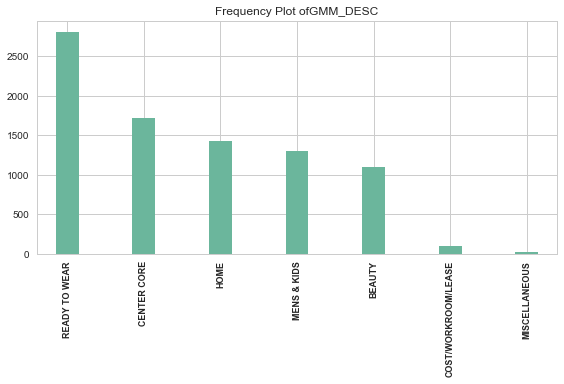

In [48]:
freq_plt(tot_data,'GMM_DESC')


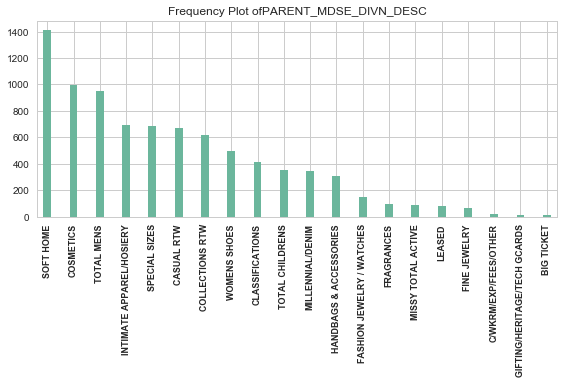

In [49]:
freq_plt(tot_data,'PARENT_MDSE_DIVN_DESC')


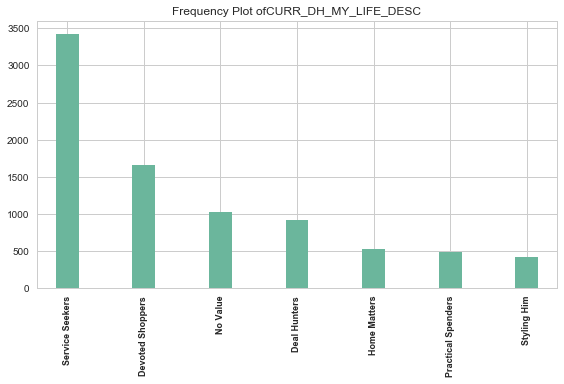

In [50]:
freq_plt(tot_data,'CURR_DH_MY_LIFE_DESC')


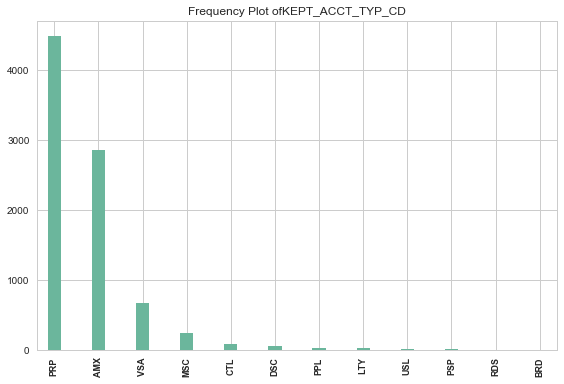

In [51]:
freq_plt(tot_data,'KEPT_ACCT_TYP_CD')


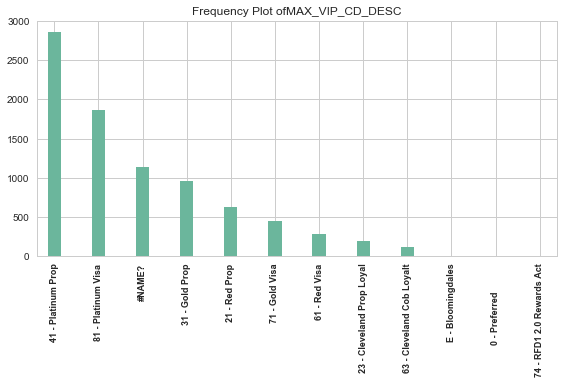

In [52]:
freq_plt(tot_data,'MAX_VIP_CD_DESC')


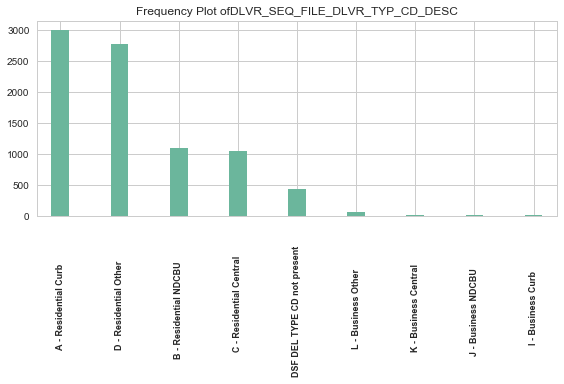

In [53]:
freq_plt(tot_data,'DLVR_SEQ_FILE_DLVR_TYP_CD_DESC')


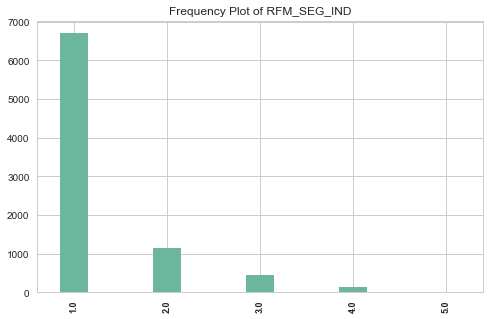

In [54]:
plt.figure(figsize=(8,5))
ax=tot_data.loc[tot_data.RFM_SEG_IND!=0,'RFM_SEG_IND'].value_counts().plot(kind='bar',width=0.3,color="#6bb69c",title='Frequency Plot of RFM_SEG_IND')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=5,size=9,rotation=90,fontweight="bold")

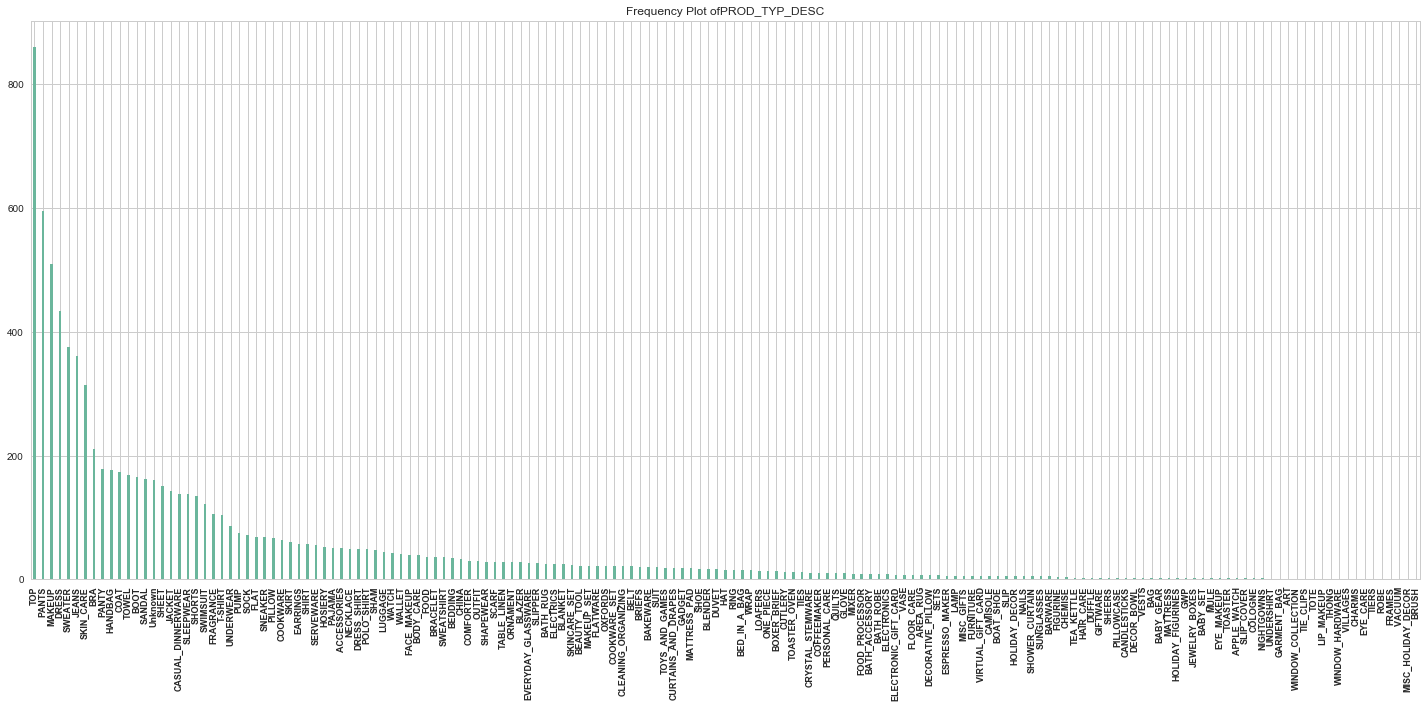

In [146]:
plt.figure(figsize=(20,10))
freq_plt(tot_data,'PROD_TYP_DESC')

#### Age with Return Status 

In [55]:
dates_consider=['DOB_DT']
for col in dates_consider:
    tot_data[col]=pd.to_datetime(tot_data[col])


In [56]:
from datetime import datetime
tot_data.dropna(subset=['DOB_DT'],inplace=True,how='any')
import datetime
tot_data['y']=(tot_data.DOB_DT).dt.year
tot_data['age']=(2017-tot_data.y)
#plt.xticks(X,df.Level_Name , rotation=45,fontsize=9,fontweight='bold')

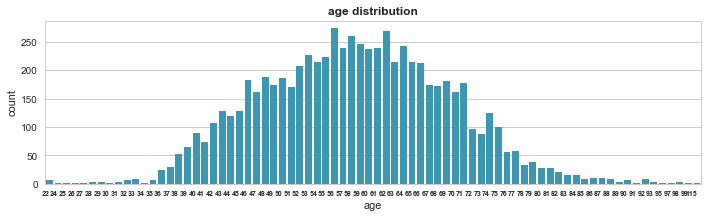

In [57]:
plt.figure(figsize=(10,3))
ax = sns.countplot(x="age", data=tot_data,color='#29A2C6')

ax.set_xticklabels(ax.get_xticklabels(),fontsize=5, ha="right",size=7,fontweight='bold')
plt.tight_layout()
plt.title("age distribution",fontweight='bold')
plt.savefig("age.png")
plt.show()



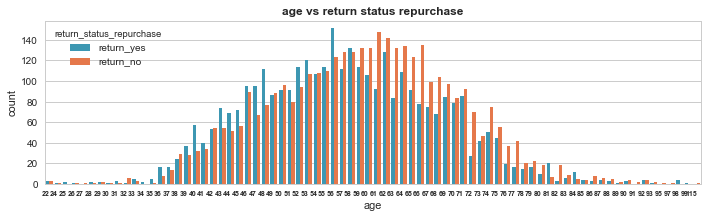

Customers whos age is above 60 - years ,thay are less probable to return the products


In [58]:
plt.figure(figsize=(10,3))
ax = sns.countplot(x="age", data=tot_data,hue="return_status_repurchase", palette=['#29A2C6','#FF6D31'])

ax.set_xticklabels(ax.get_xticklabels(),fontsize=5, ha="right",size=7,fontweight='bold')
plt.tight_layout()
plt.title("age vs return status repurchase",fontweight='bold')
plt.savefig("ag.png")
plt.show()
print("Customers whos age is above 60 - years ,thay are less probable to return the products")

In [59]:
tot_data.dropna(subset=['RFM_SEG_IND','TOT_BUY_AMT','TOT_RET_AMT','TOT_BUY_QTY'],inplace=True,how='any')

In [60]:
### Here, iam removing rows (which are having RFM_SEG_IND==0.0,we observed 3 - instances )
def bivar_plt(data,attribute,title_size=15,fig_width=12,fig_height=4,bar_width=0.3):
    fig, axs = plt.subplots(1,2,figsize=(fig_width,fig_height),squeeze=0)
    
    pd.crosstab(data.loc[data[attribute]!=0,attribute],data.return_status_repurchase,normalize='index').plot(kind='bar',width=bar_width,ax=axs[0][0],color=['#FF6D31','#29A2C6'])
    axs[0, 0].set_title(attribute + ' VS Returns',size=title_size,fontname="Arial",fontweight="bold")
    plt.setp(axs[0, 0].get_xticklabels(),rotation=65,size=12)
    axs[0, 0].set_xlabel(attribute,size=13,fontname="Calibri")
    axs[0,0].set_ylabel('Proportion',size=13,fontname="Calibri")

    axs[0,0].legend(bbox_to_anchor=(1.0, 0.9),loc='right')
    data.loc[data[attribute]!=0,attribute].value_counts().plot(kind='bar',ax=axs[0][1],width=0.3,color=['#6bb69c'])
    plt.title('Frequency of Categories',size=13,fontname="Arial",fontweight="bold")
    plt.setp(axs[0, 1].get_xticklabels(),rotation=65,size=12)
    axs[0,1].set_xlabel(attribute,size=13,fontname="Calibri",)
    axs[0,1].set_ylabel('Frequency',size=13,fontname="Calibri")
    plt.tight_layout()
    plt.savefig("RFM_P1.png")
       
    



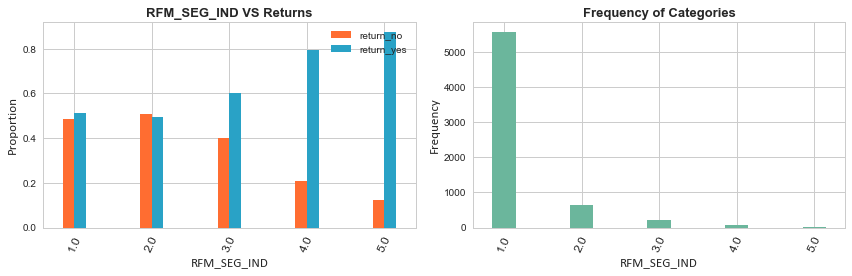

In [61]:
bivar_plt(tot_data,'RFM_SEG_IND',title_size=13)

In [62]:
tot_data.dropna(subset=['RFM_SEG_IND','TOT_BUY_AMT','TOT_RET_AMT','TOT_BUY_QTY'],inplace=True,how='any')

In our Data Most of the Customers are non - employee Customers ,and if We observe that ,the Customers who are non- employers and who are spending large amount they are not probable to retun the Products & EMP_IND = Y, they are spending less amount


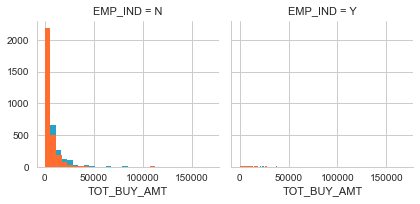

In [63]:
g = sns.FacetGrid(tot_data, col='EMP_IND',hue='return_status_repurchase',palette=['#29A2C6','#FF6D31'])
g.map(plt.hist, 'TOT_BUY_AMT', bins=30)
#g.savefig("TOT_BUY_AMT with returns.png")
print("In our Data Most of the Customers are non - employee Customers ,and if We observe that ,the Customers who are non- employers and who are spending large amount they are not probable to retun the Products & EMP_IND = Y, they are spending less amount")

In [64]:
tot_data.drop(['PRIZM_DESC'],axis = 1 , inplace = True)

### Histograms (Compare Continuous vs Categorical variables):

In [70]:
def hist_var(data,attribute,bin_size=50,title_size = 10):
    
    plt.figure(figsize=(8,5))
    _, edges = np.histogram(data[attribute], bins=50)
    histdata = []; labels=[]
    for n, group in data.groupby("return_status_repurchase"):
        histdata.append(np.histogram(group[attribute], bins=edges)[0])
        labels.append(n)
    
    hist = np.array(histdata) 
    histcum = np.cumsum(hist,axis=0)
    
    plt.bar(edges[:-1],hist[0,:], width=np.diff(edges)[0],
                label=labels[0], align="edge",color='#FF6D31',alpha=0.7)
    
    for i in range(1,len(hist)):
        plt.bar(edges[:-1],hist[i,:], width=np.diff(edges)[0],
                bottom=histcum[i-1,:],label=labels[i], align="edge",color='#29A2C6',alpha=0.5)
   # attribute = 'time_to_new_purchase'
    plt.legend(title="return status",labels=['return_no','return_yes'])
    plt.title('Distribution of '+ attribute,fontweight='bold',size=title_size)
    plt.xlabel(attribute,size=15)
    plt.ylabel('Frequency',size=15)
    plt.savefig(attribute + ".png")
    plt.show()    

### Continuous vs Target:

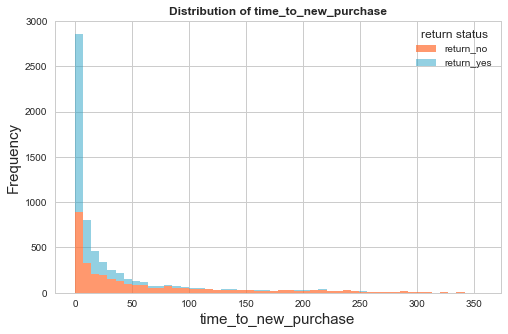

time taken for new transactions are 60 - days


In [67]:
hist_var(tot_data,'time_to_new_purchase',title_size=12) 
print("time taken for new transactions are 60 - days")

In [68]:
# def hist_var(data,attribute,bin_size=5,title_size = 10):
    
#     plt.figure(figsize=(8,5))
#     _, edges = np.histogram(data[attribute], bins=[0, 10, 20, 30, 40, 50, 100])
#     histdata = []; labels=[]
#     for n, group in data.groupby("return_status_repurchase"):
#         histdata.append(np.histogram(group[attribute], bins=edges)[0])
#         labels.append(n)
    
#     hist = np.array(histdata) 
#     histcum = np.cumsum(hist,axis=0)
    
#     plt.bar(edges[:-1],hist[0,:], width=np.diff(edges)[0],
#                 label=labels[0], align="edge",color='#FF6D31',alpha=0.7)
    
#     for i in range(1,len(hist)):
#         plt.bar(edges[:-1],hist[i,:], width=np.diff(edges)[0],
#                 bottom=histcum[i-1,:],label=labels[i], align="edge",color='#29A2C6',alpha=0.5)
#    # attribute = 'time_to_new_purchase'
#     plt.legend(title="return status",labels=['return_no','return_yes'])
#     plt.title('Distribution of '+ attribute,fontweight='bold',size=title_size)
#     plt.xlabel(attribute,size=15)
#     plt.ylabel('Frequency',size=15)
#     plt.savefig(attribute + "1.png")
#     plt.show() 
    

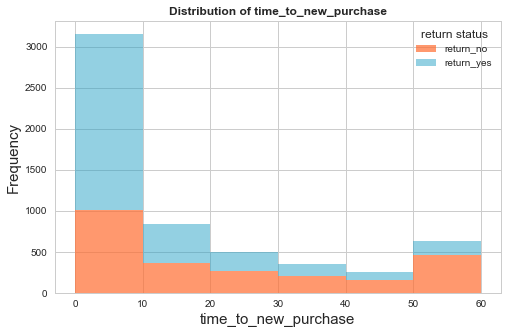

added bins


In [69]:
# hist_var(tot_data,'time_to_new_purchase',title_size=12)
# print("added bins")

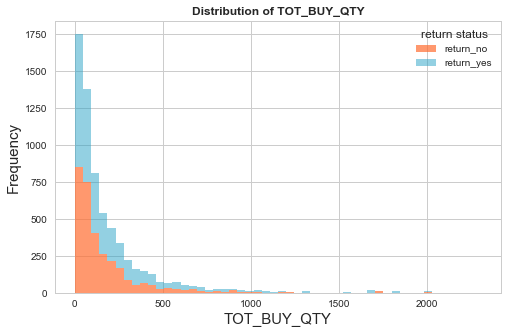

In [71]:
hist_var(tot_data,'TOT_BUY_QTY',title_size=12)   

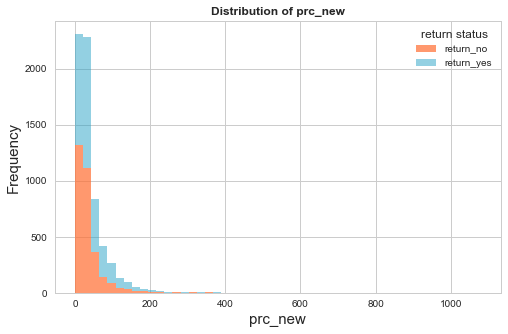

In [72]:
hist_var(tot_data,'prc_new',title_size=12)    

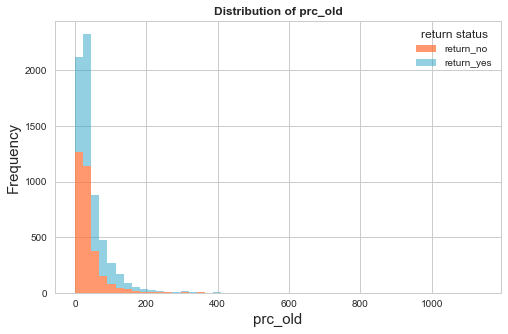

In [73]:
hist_var(tot_data,'prc_old',title_size=12)    

In [74]:
### Here , iam just changing the bins - size
def hist_var(data,attribute,bin_size=5,title_size = 10):
    
    plt.figure(figsize=(8,5))
    _, edges = np.histogram(data[attribute], bins=[-10,-5,0,5,10,15,20,25,30,35,40,45,50,55])
    histdata = []; labels=[]
    for n, group in data.groupby("return_status_repurchase"):
        histdata.append(np.histogram(group[attribute], bins=edges)[0])
        labels.append(n)
    
    hist = np.array(histdata) 
    histcum = np.cumsum(hist,axis=0)
    
    plt.bar(edges[:-1],hist[0,:], width=np.diff(edges)[0],
                label=labels[0], align="edge",color='#FF6D31',alpha=0.7)
    
    for i in range(1,len(hist)):
        plt.bar(edges[:-1],hist[i,:], width=np.diff(edges)[0],
                bottom=histcum[i-1,:],label=labels[i], align="edge",color='#29A2C6',alpha=0.5)
   # attribute = 'time_to_new_purchase'
    plt.legend(title="return status",labels=['return_no','return_yes'])
    plt.title('Distribution of '+ attribute,fontweight='bold',size=title_size)
    plt.xlabel(attribute,size=15)
    plt.ylabel('Frequency',size=15)
    plt.savefig(attribute + "1.png")
    plt.show()    

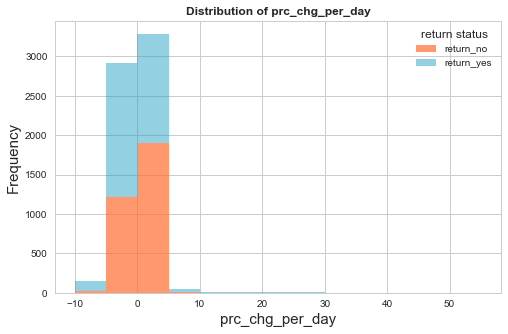

When newly purchased product price is higher than older product price , they are most probable to return the products


In [75]:
hist_var(tot_data,'prc_chg_per_day',title_size=12) 
print("When newly purchased product price is higher than older product price , they are most probable to return the products")

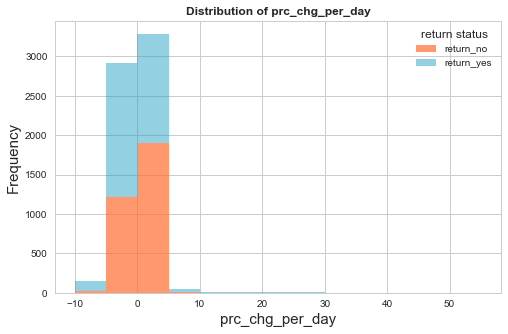

In [76]:
#tot_data.
hist_var(tot_data,'prc_chg_per_day',title_size=12) 

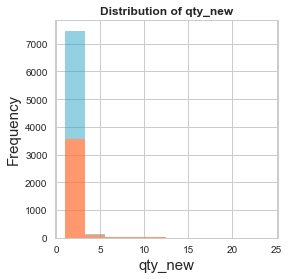

In [327]:
tot_data.qty_new
hist_var(tot_data,'qty_new',title_size=12) 

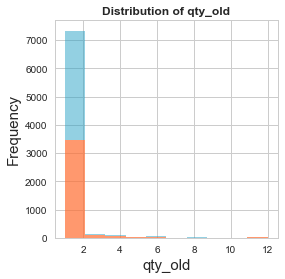

In [328]:
hist_var(tot_data,'qty_old',title_size=12)

In [330]:
tot_data['diff_qty']=(tot_data.qty_new-tot_data.qty_old)

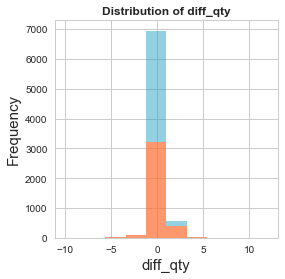

In [331]:
hist_var(tot_data,'diff_qty',title_size=12) 

In [253]:
## Changing bin size
def hist_var(data,attribute,bin_size=3,title_size = 10):
    
    plt.figure(figsize=(8,5))
    _, edges = np.histogram(data[attribute], bins=[0,0.2,0.4,0.6,0.8,1.0])
    histdata = []; labels=[]
    for n, group in data.groupby("return_status_repurchase"):
        histdata.append(np.histogram(group[attribute], bins=edges)[0])
        labels.append(n)
    
    hist = np.array(histdata) 
    histcum = np.cumsum(hist,axis=0)
    
    plt.bar(edges[:-1],hist[0,:], width=np.diff(edges)[0],
                label=labels[0], align="edge",color='#FF6D31',alpha=0.6)
    
    for i in range(1,len(hist)):
        plt.bar(edges[:-1],hist[i,:], width=np.diff(edges)[0],
                bottom=histcum[i-1,:],label=labels[i], align="edge",color='#29A2C6',alpha=0.6)
   # attribute = 'time_to_new_purchase'
    plt.legend(title="return status",labels=['return_no','return_yes'])
    plt.title('Distribution of '+ attribute,fontweight='bold',size=title_size)
    plt.xlabel(attribute,size=15)
    plt.ylabel('Frequency',size=15)
    plt.savefig(attribute + "11.png")
    plt.show()    

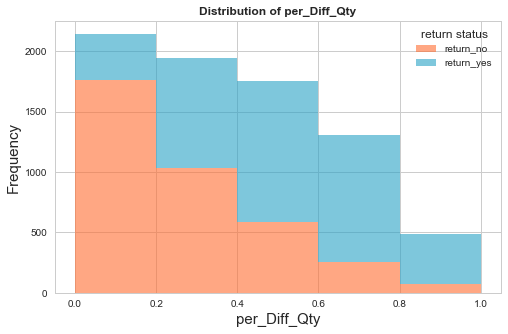

In [254]:
hist_var(tot_data,'per_Diff_Qty',title_size=12) 
#tot_data.per_Diff_Qty

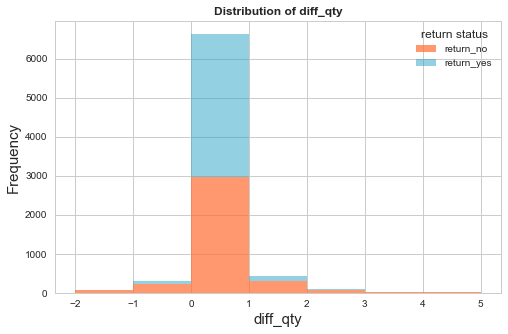

Most of the Customers are Purchasing either same quantity of products or they are purchasing 1 more higher than old quantity,and in this case returns are also higher


In [333]:
hist_var(tot_data,'diff_qty',title_size=12) 
print("Most of the Customers are Purchasing either same quantity of products or they are purchasing 1 more higher than old quantity,and in this case returns are also higher")

In [334]:
tot_data.shape

(7671, 63)

### Stacked Plots (Compare proportion of two categorical variables)

In [273]:
import pylab
def prop_level_cnt(var_name):
    df =pd.DataFrame()
    for i in range(len(tot_data[var_name].unique())):
        level_name = pd.DataFrame(tot_data[var_name].value_counts()).index[i]
        lev_cnt = tot_data[var_name].value_counts()[i]
        yes_prop = tot_data.loc[(tot_data[var_name]==level_name)&(tot_data.return_status_repurchase=='return_yes'),].shape[0]/lev_cnt
#         no_prop = tot_data.loc[(tot_data[var_name]==level_name)&tot_data.return_status_repurchase==0,].shape[0]/lev_cnt
        df.loc[i-1,'Level_Name']=level_name
        df.loc[i-1,'Return_yes_proportion']=yes_prop
        df.loc[i-1,'Return_no_proportion']=1-yes_prop
#         df=df.reset_inde )
#         df.drop(['index'],axis=1)
    X = range(df.shape[0])
    plt.figure(figsize=(5,5))
    plt.bar(X, df.Return_yes_proportion, color = '#29A2C6',label='return_yes',width=0.6)
    plt.bar(X, df.Return_no_proportion, color = '#FF6D31', bottom = df.Return_yes_proportion,label='return_no',width=0.6)
    plt.xticks(X,df.Level_Name , rotation=90,fontsize=9,fontweight='bold')
    plt.title(var_name + " VS  Return Status",fontweight='bold',fontsize=15)
    plt.ylabel("Proportion",fontsize=15)
    plt.xlabel('Categories',fontsize=15,fontweight='bold')
    plt.legend(bbox_to_anchor=(1.0, 0.8),loc='right')
    plt.tight_layout()
    plt.savefig(var_name +"11plot.png")
    
    #pylab.legend(loc=9, bbox_to_anchor=(5,5))
    plt.show()
    #axs[0,0].legend(bbox_to_anchor=(1.1, 1.05),loc='right')

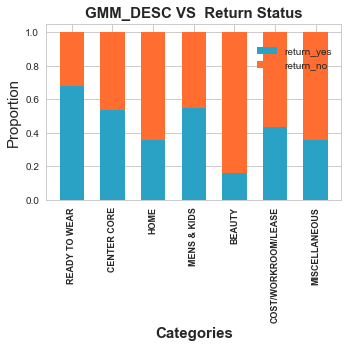

In [111]:
prop_level_cnt('GMM_DESC')

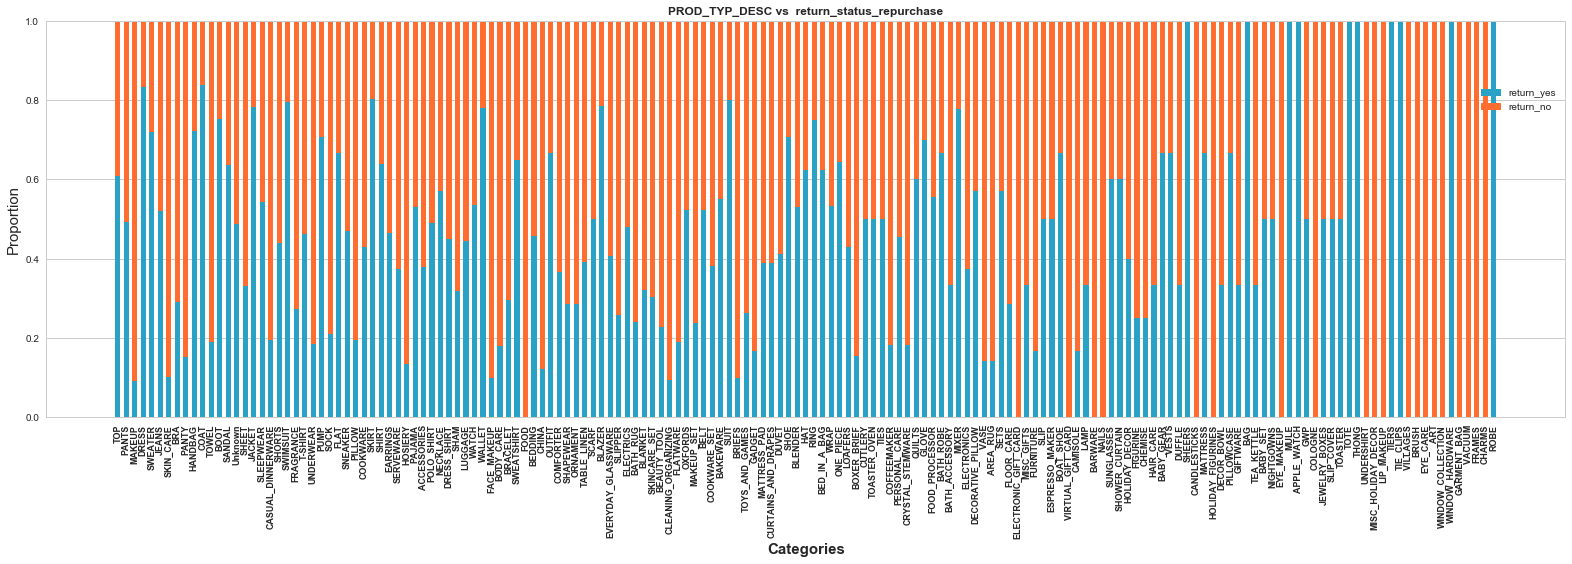

In [73]:
prop_level_cnt('PROD_TYP_DESC')
print("from TOPS and DRESSES higher returns are happening")

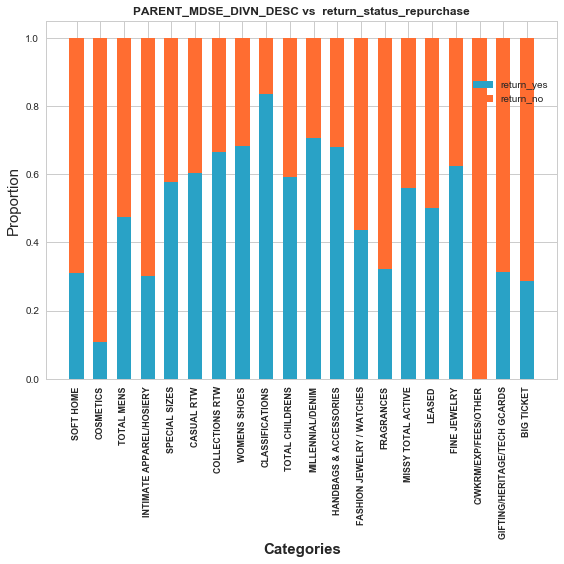

In [75]:
prop_level_cnt('PARENT_MDSE_DIVN_DESC')

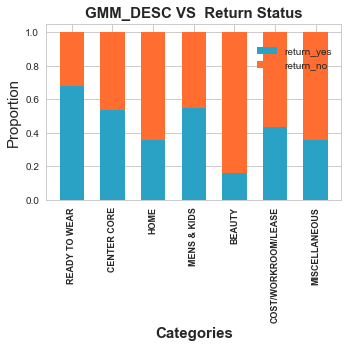

From Ready to Wear Most of the returns are happening


In [274]:
prop_level_cnt('GMM_DESC')
print("From Ready to Wear Most of the returns are happening")

There is only 0.1% more chances that,they will return the product , if customer is having SMS_IND


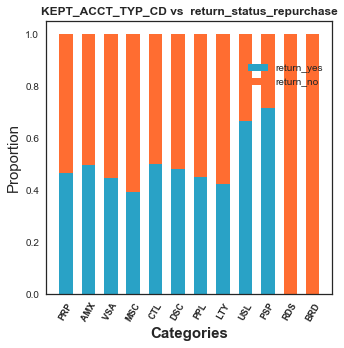

In [326]:
print("There is only 0.1% more chances that,they will return the product , if customer is having SMS_IND")
prop_level_cnt('KEPT_ACCT_TYP_CD')

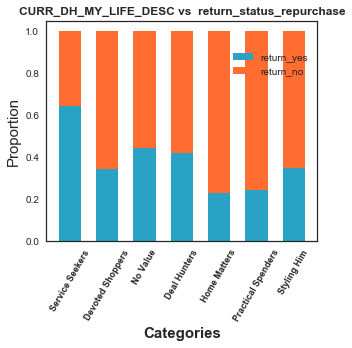

In [327]:
prop_level_cnt('CURR_DH_MY_LIFE_DESC')


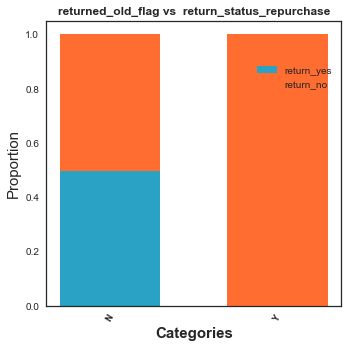

In [337]:
prop_level_cnt('returned_old_flag')

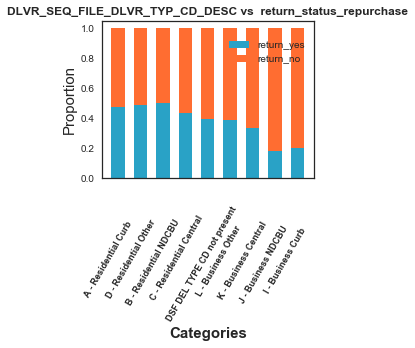

In [419]:

prop_level_cnt('DLVR_SEQ_FILE_DLVR_TYP_CD_DESC')

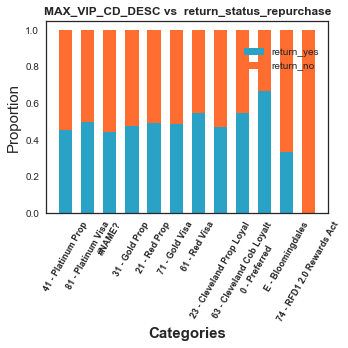

In [420]:

prop_level_cnt('MAX_VIP_CD_DESC')

#### Correlation plot

In [117]:
tot_data['return_status_repurchase']=tot_data.return_status_repurchase.astype('str')

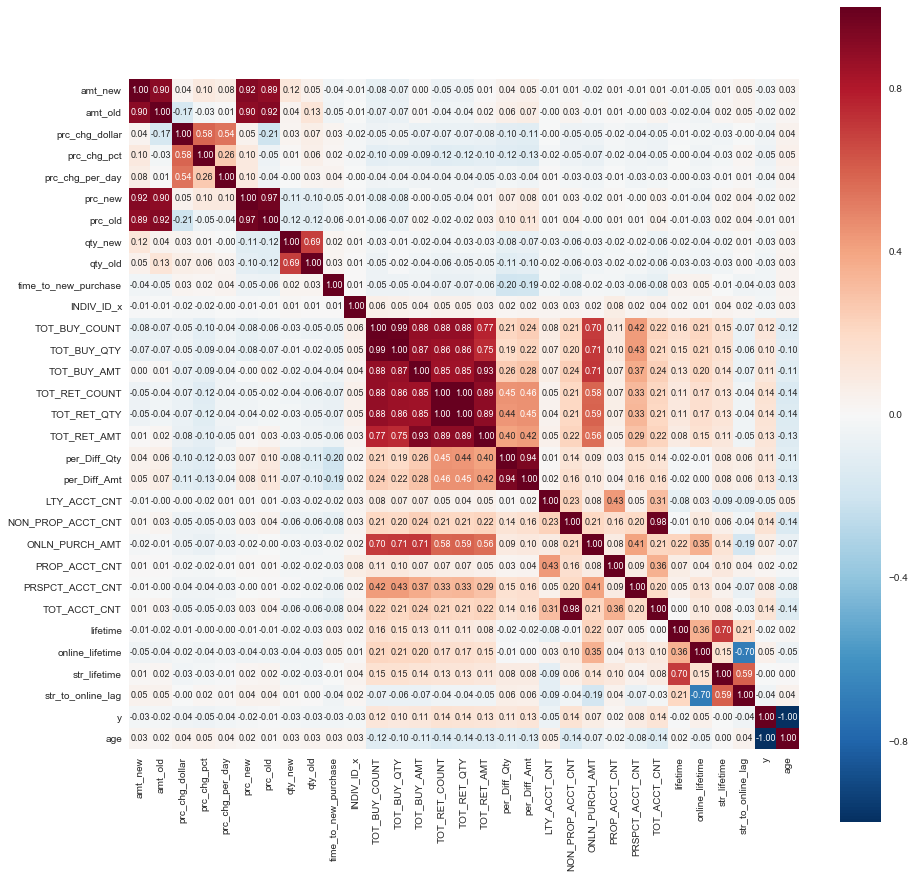

In [119]:
plt.figure(figsize=(15,15))
sns.heatmap(tot_data.corr(),cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 9})


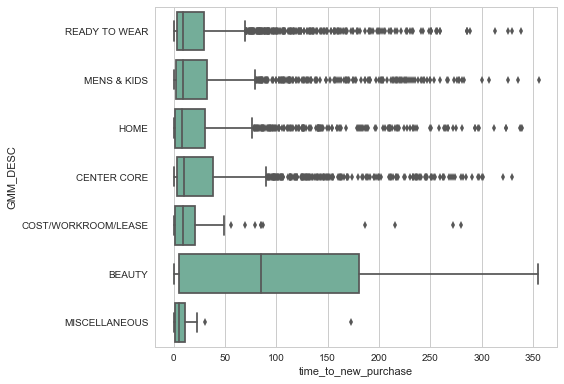

In [312]:
sns.boxplot(x='time_to_new_purchase',y='GMM_DESC',data=tot_data,color='#6bb69c')
plt.tight_layout()
plt.savefig("Gmmvstime.png")

### To Know Customers Behaviour 

In [266]:
tot_data.dropna(subset=['DOB_DT'],how='any',inplace=True)

In [267]:
dates_consider=['DOB_DT']
for col in dates_consider:
    tot_data[col]=pd.to_datetime(tot_data[col])


In [268]:
from datetime import datetime
tot_data.dropna(subset=['DOB_DT'],inplace=True,how='any')
import datetime
tot_data['y']=(tot_data.DOB_DT).dt.year
tot_data['age']=(2017-tot_data.y)

In [269]:
tot_data.loc[(tot_data['age'] <= 59),'age_bin']='below_60'

In [270]:
tot_data.loc[(tot_data['age'] >= 60),'age_bin']='above_60'

#### Chi - square test on age & gender vs return_status_repurchase

In [289]:
table = pd.crosstab(tot_data.age_bin,tot_data.return_status_repurchase)

from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table.values)
print ('Chi-square Statistic %0.3f p_value %0.3f' % (chi2, p))
print("\n")
print("there is asignificant different between groups")

Chi-square Statistic 49.760 p_value 0.000


there is asignificant different between groups


In [284]:
table = pd.crosstab(tot_data.return_status_repurchase,tot_data.GNDR_CD)
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table.values)
print ('Chi-square Statistic %0.3f p_value %0.3f' % (chi2, p))
print("there is asignificant different between groups")

Chi-square Statistic 12.161 p_value 0.002
there is asignificant different between groups


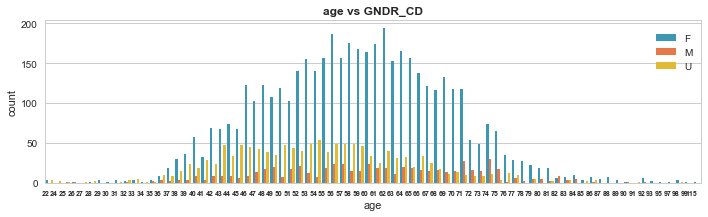

In [307]:
plt.figure(figsize=(10,3))
ax = sns.countplot(x="age", data=tot_data,hue="GNDR_CD", palette=['#29A2C6','#FF6D31','#FFCB18'])

ax.set_xticklabels(ax.get_xticklabels(),fontsize=5, ha="right",size=7,fontweight='bold')
plt.tight_layout()
# plt.bar(X, df.Return_yes_proportion, color = 'b',label='Return_YES',width=0.8)
# plt.bar(X, df.Return_no_proportion, color = 'r', bottom = df.Return_yes_proportion,label='Return_NO',width=0.8)
plt.title("age vs GNDR_CD",fontweight='bold')
plt.savefig("agvsgender.png")
plt.legend(bbox_to_anchor=(1.0, 0.8),loc='right')
plt.show()
print("after 60-years we are having less no of  u- Category customers eventhough females are same , returns are also less happening")

### Combined Frequency plot and Stacked plots:

In [309]:
def bivar_plot1(data,attribute,fig_widht=12,fig_height=6,width=0.5,Stacked=True,legend=True):
    fig, axs = plt.subplots(1,2,figsize=(fig_widht,fig_height),squeeze=0)
    sorted_names = data[attribute].value_counts().index
    temp_df = pd.crosstab(data[attribute],data.return_status_repurchase,normalize='index')
    temp_df.reset_index(inplace=True)
    temp_df.columns = ['Levels','return_no','return_yes']
    temp_df2 = pd.DataFrame(sorted_names)
    temp_df2.columns = ['Levels']
    df_Final = pd.merge(temp_df2,temp_df,left_on='Levels',right_on='Levels')
    df_Final.plot(kind='bar',stacked=Stacked,legend=0,color=['#FF6D31','#29A2C6'],ax=axs[0,0],width=width)
    axs[0,0].set_xticklabels(df_Final.Levels, rotation='90',size=13)
    axs[0,0].set_title(attribute+ ' vs Target',size=16,fontweight='bold')
    if(legend==True):
        axs[0,0].legend(bbox_to_anchor=(1.1, 1.05),loc='right')
   
   ##-----------------plot for to notic count of each level in categorical attribute-------##
   
    data[attribute].value_counts().plot(kind='bar',ax=axs[0][1],width=width,color='#6bb69c')
    plt.title('Frequency of Categories',size=16,fontname="Arial",fontweight="bold")
    plt.setp(axs[0, 1].get_xticklabels(),rotation='90',size=13)
#     axs[0,1].set_xlabel(attribute,size=15,fontname="Calibri")
    axs[0,1].set_ylabel('Frequency',size=15,fontname="Calibri")
    #if(legend==True):
        #axs[0,1].legend(bbox_to_anchor=(1.1, 1.05),loc='right')
    plt.tight_layout()
    plt.savefig(attribute+'22.png')
    
   
#    ##-----------------plot for to find return rate for each level of categorical attribute-------##
   
   

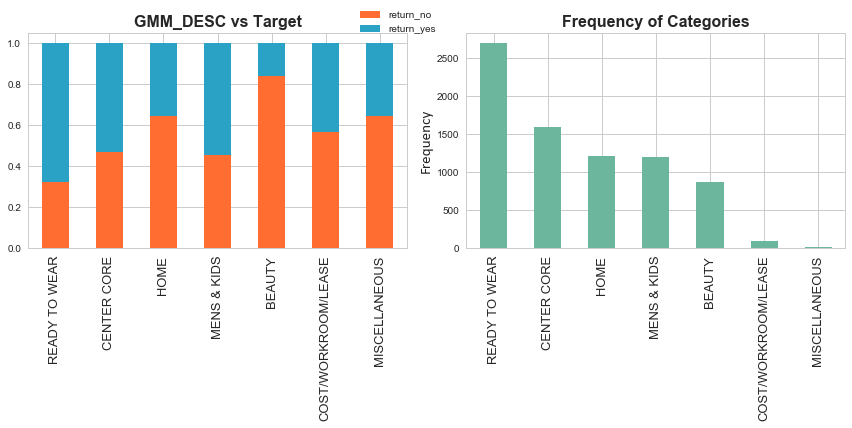

In [299]:
bivar_plot1(tot_data,'GMM_DESC')

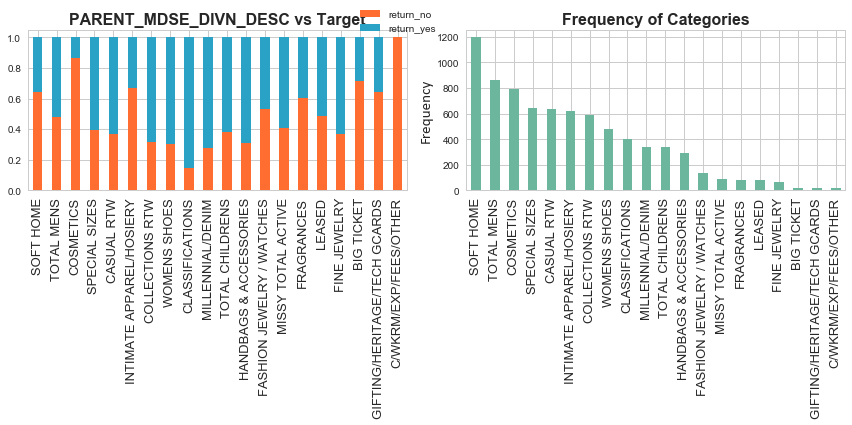

In [300]:
bivar_plot1(tot_data,'PARENT_MDSE_DIVN_DESC')

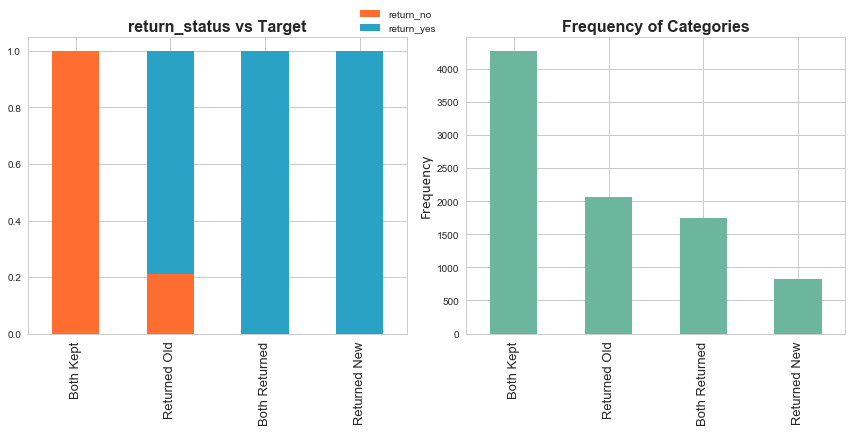

In [311]:
bivar_plot1(new_data,'return_status')

In [330]:
tot_data.loc[(tot_data.time_to_new_purchase<=60)&(tot_data.time_to_new_purchase>=50),].shape

(246, 62)

In [336]:
tot_data.loc[(tot_data.time_to_new_purchase<=60)&(tot_data.time_to_new_purchase>=50),].shape

(246, 62)